In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from utils.rff import *
from typing import Optional

from PIL import Image
import numpy as np
from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import regex as re
import seaborn as sns

DATA_DIR = "./data"

In [2]:
# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor()
# )

# test_data = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor()
# )

In [3]:
def load_dat_file(path, sep=",", y_pos=-1, x_transform=None, y_transform=None):
    
    x_data = []
    y_data = []

    if x_transform is None:
        def x_transform(x):
            return x

    if y_transform is None:
        def y_transform(y):
            return y

    with open(path, "r") as file:
        for line in file:
            if "@" in line:
                continue
            line = line.replace('\n', '')
            elements = str2list(line, sep)
            if y_pos is not None:
                y_data.append(y_transform(elements.pop(y_pos)))
            # print(elements)
            x_data.append(x_transform(elements))
    return x_data, y_data

def str2list(string, sep=","):
    return string.split(sep)

def australian_transform_x(x):
    isnumber = re.compile(r'\d+(?:,\d*)?')
    return [float(ele) if isnumber.search(ele) else ele for ele in x]

def australian_transform_y(y):
    return int(y)

def balance_transform_x(x):
    return [float(ele) for ele in x]

def balance_transform_y(y):
    if y == " B":
        return 0
    elif y == " R":
        return 1
    elif y == " L":
        return 2

def magic_transform_x(x):
    return [float(ele) for ele in x]

def magic_transform_y(y):
    if y == "g":
        return 0
    elif y == "h":
        return 1

def monk_transform_x(x):
    return [float(ele) for ele in x]

def monk_transform_y(y):
    return int(y)

def sonar_transform_x(x):
    return [float(ele) for ele in x]

def sonar_transform_y(y):
    if y == " R":
        return 0
    elif y == " M":
        return 1

def spambase_transform_x(x):
    return [float(ele) for ele in x]

def spambase_transform_y(y):
    return int(y)

def titanic_transform_x(x):
    return [float(ele) for ele in x]

def titanic_transform_y(y):
    if y=="-1.0":
        return 0
    elif y=="1.0":
        return 1

def CNAE_transform_x(x):
    return [float(ele) for ele in x]

def CNAE_transform_y(y):
    return int(y) - 1

def covertype_transform_x(x):
    return [float(ele) for ele in x]

def covertype_transform_y(y):
    return int(y)

def madelon_transform_x(x):
    return [float(ele) for ele in x[:-1]]

def madelon_transform_y(y):
    assert len(y) == 1
    if y[0] == "-1":
        return 0
    elif y[0] == "1":
        return 1

In [4]:
def unique_in_list(l):
    u = []
    for item in l:
        if item not in u:
            u.append(item)
    return u

In [5]:
class BaseDataset(Dataset):
    def __init__(self, x: list, y: list):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y).long()
                
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class MLRepositoryDatasetGenerator():

    """FOR FUTURE IMPROVEMNT: BUILD A CLASS/FUNC THAT AUTOMATICALLY CREATES TEST/TRAIN SET ON DISK INSTEAD OF IN MEMORY TO IMPROVE EFFICIENCY."""

    def __init__(self, name: str, test_size=0.2, seed=42, verbose=True) -> None:
        self._load_dataset(name)
        if verbose:
            print(f"The explanatory data contains {len(self.x[0])} features")
            print(f"There are {len(unique_in_list(self.y))} target classes")

        self._instantiate_train_test(test_size, seed)

    def __call__(self, mode: str):
        if mode == "train":
            return BaseDataset(self.train_x, self.train_y)
        elif mode == "test":
            return BaseDataset(self.test_x, self.test_y)
        else:
            raise ValueError(f"Either 'train' or 'test' can be passed as valid modes. Got '{mode}' instead")
    
    def _instantiate_train_test(self, test_size, seed):
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(self.x, self.y, test_size=test_size, random_state=seed)
        del self.x, self.y

    def _load_dataset(self, name: str):
        if name == "australian":
            self.x, self.y = load_dat_file(DATA_DIR + "/spambase/spambase.dat", x_transform=spambase_transform_x, y_transform=spambase_transform_y)
        elif name == "balance":
            self.x, self.y = load_dat_file(DATA_DIR + "/balance/balance.dat", x_transform=balance_transform_x, y_transform=balance_transform_y)
        elif name == "magic":
            self.x, self.y = load_dat_file(DATA_DIR + "/magic/magic.dat", x_transform=magic_transform_x, y_transform=magic_transform_y)
        elif name == "monk-2":
            self.x, self.y = load_dat_file(DATA_DIR + "/monk-2/monk-2.dat", x_transform=monk_transform_x, y_transform=monk_transform_y)
        elif name == "sonar":
            self.x, self.y = load_dat_file(DATA_DIR + "/sonar/sonar.dat", x_transform=sonar_transform_x, y_transform=sonar_transform_y)
        elif name == "titanic":
            self.x, self.y = load_dat_file(DATA_DIR + "/titanic/titanic.dat", x_transform=titanic_transform_x, y_transform=titanic_transform_y)
        elif name == "spambase":
            self.x, self.y = load_dat_file(DATA_DIR + "/spambase/spambase.dat", x_transform=spambase_transform_x, y_transform=spambase_transform_y)
        elif name == "CNAE-9":
            self.x, self.y = load_dat_file(DATA_DIR + "/CNAE-9/CNAE-9.data", y_pos=0, x_transform=CNAE_transform_x, y_transform=CNAE_transform_y)
        elif name == "covertype":
            self.x, self.y = load_dat_file(DATA_DIR + "/covertype/covtype.data", x_transform=covertype_transform_x, y_transform=covertype_transform_y)
        elif name == "madelon":
            self.x, _ = load_dat_file(DATA_DIR + "/madelon/madelon_train.data", y_pos=None, x_transform=madelon_transform_x, sep=" ")
            self.y, _ = load_dat_file(DATA_DIR + "/madelon/madelon_train.labels", y_pos=None, x_transform=madelon_transform_y)
        else:
            raise ValueError(f"The dataset {name} has not been implemented yet or does not exist")

In [6]:
# X, y = make_moons(n_samples=100, noise=0.1)

# y = y*2 - 1 # make y be -1 or 1
# # visualize in 2D
# plt.figure(figsize=(5,5))
# plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [7]:
def all_exist(avalue, bvalue):
    return all(any(i in j for j in bvalue) for i in avalue)

class Mehrkanoon(nn.Module):
    def __init__(self, input_size: int, layer_shapes: dict, sigma: list):
        super(Mehrkanoon, self).__init__()

        self.flatten = nn.Flatten()
        
        self.keys = list(layer_shapes.keys())
        self.layer_shapes = layer_shapes
        self.sigma = sigma
        self.input_size = input_size
        self.head = False
    
        if all_exist(["h1", "h2", "s"], self.keys):           
            self.model = nn.Sequential(
                nn.Linear(self.input_size, self.layer_shapes['h1']),
                RandomFourierFeatureLayer(self.layer_shapes['h1'], self.layer_shapes['h2'], sigma=self.sigma[0]),
                nn.Linear(self.layer_shapes['h2'], self.layer_shapes['s'])        
            )
        elif "s" in self.keys:
            raise ValueError(f"The layer shapes should include layer shapes for 'h1' and 'h2' but instead got shapes for {self.keys}")
        else:
            raise ValueError(f"The layer shapes should atleast include layer shapes for 'h1','h2', and 's' but instead got shapes for {self.keys}")
    
    def add_head(self, freeze_body=False):
        if self.head:
            print("Head has already been added")
        elif all_exist(["h1", "h2", "h3", "h4", "s"], self.keys):
            self.head = True
            self.model.pop(-1)

            if freeze_body:
                for i in range(len(self.model)):
                    for param in self.model[i].parameters():
                        param.requires_grad = False

            self.model.append(nn.Linear(self.layer_shapes['h2'], self.layer_shapes['h3']))
            self.model.append(RandomFourierFeatureLayer(self.layer_shapes['h3'], self.layer_shapes['h4'], sigma=self.sigma[1]))
            self.model.append(nn.Linear(self.layer_shapes['h4'], self.layer_shapes['s']))
        else:
            raise ValueError(f"The layer shapes should include layer shapes for 'h1', 'h2', 'h3' and 'h4' but instead got shapes for {self.keys}")

    def forward(self, x):
        x = self.flatten(x)
        x = self.model(x)
        return x

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    loss_history = []
    accuracy_history = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            loss_history.append(loss)
            accuracy_history.append(correct/len(X))
            if verbose:
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return np.mean(np.array(loss_history)), np.mean(np.array(accuracy_history))
    
def test_loop(dataloader, model, loss_fn, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct



In [9]:
class ModelTrainer():

    def __init__(self, model, train_data, 
                              test_data, 
                              loss_fn, optimizer, batch_size, epochs, learning_rate, verbose=True) -> None:
        self.model = model
        self.train_data = train_data
        self.test_data = test_data
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.epochs = epochs
        self.current_epoch = 0
        self.verbose = verbose
        self._fitted = False

        self.history = {'train_loss': [],
                        'test_loss': [],
                        'train_accuracy': [],
                        'test_accuracy': []}
    
    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs
        for t in range(epochs):
            self.current_epoch += 1
            if self.verbose:
                print(f"Epoch {self.current_epoch}\n-------------------------------")
            train_loss, train_accuracy = train_loop(self.train_data, self.model, self.loss_fn, self.optimizer, verbose=self.verbose)
            test_loss, test_accuracy = test_loop(self.test_data, self.model, self.loss_fn, verbose=self.verbose)
            self.history['train_loss'].append(train_loss)
            self.history['train_accuracy'].append(train_accuracy)
            self.history['test_loss'].append(test_loss)
            self.history['test_accuracy'].append(test_accuracy)
        print("Done!")
        self._fitted = True

    def plot(self, metric):
        if metric == "loss":
            sns.lineplot(y=self.history['train_loss'], x=range(self.current_epoch))
            sns.lineplot(y=self.history['test_loss'], x=range(self.current_epoch))
        if metric == "accuracy":
            sns.lineplot(y=self.history['train_accuracy'], x=range(self.current_epoch))
            sns.lineplot(y=self.history['test_accuracy'], x=range(self.current_epoch))

    def __repr__(self):
        return self.model

    def evaluate(self):
        size = len(self.test_data.dataset)
        num_batches = len(self.test_data)
        test_loss, correct = 0, 0

        with torch.no_grad():
            pred = self.model(self.test_data.dataset.x)
            test_loss = self.loss_fn(pred, self.test_data.dataset.y).item()
            correct = (pred.argmax(1) == self.test_data.dataset.y).type(torch.float).sum().item()

        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        print(confusion_matrix(y_pred=pred.argmax(1), y_true=self.test_data.dataset.y))



In [10]:
batch_size = 20
epochs = 50
learning_rate = 1e-3

DatasetGenerator = MLRepositoryDatasetGenerator("CNAE-9")
training_data = DatasetGenerator('train')
test_data = DatasetGenerator('test')

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

The explanatory data contains 856 features
There are 9 target classes


In [11]:
model = Mehrkanoon(856, {'h1': 300, 'h2': 400, 'h3': 200, 'h4': 100, 's': 9}, sigma=[0.8, 0.7])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)
m = ModelTrainer(model, train_dataloader, test_dataloader, loss_fn, optimizer, batch_size, epochs, learning_rate, verbose=False)

In [22]:
m.fit(1000)

Done!


In [23]:
m.evaluate()

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.841037 

[[26  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  1  0  0  0]
 [ 0  0 25  0  0  0  0  0  0]
 [ 0  0  0 28  0  2  0  0  1]
 [ 0  0  0  0 31  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0]
 [ 0  2  0  0  0  1 18  0  1]
 [ 0  0  0  0  0  0  0 19  0]
 [ 0  0  0  1  0  2  1  0 17]]


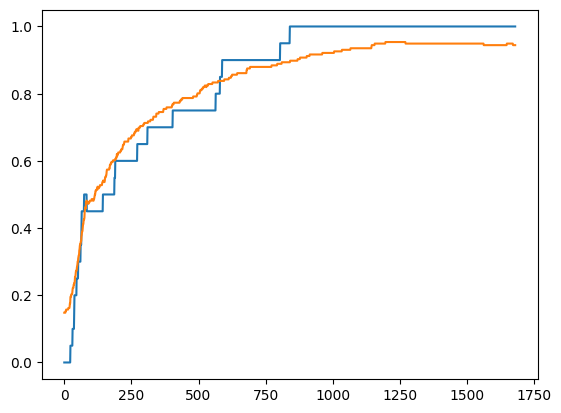

In [25]:
m.plot('accuracy')

In [26]:
model.add_head()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-3)
m = ModelTrainer(model, train_dataloader, test_dataloader, loss_fn, optimizer, batch_size, epochs, learning_rate, verbose=False)

In [27]:
model

Mehrkanoon(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=856, out_features=300, bias=True)
    (1): RandomFourierFeatureLayer()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): RandomFourierFeatureLayer()
    (4): Linear(in_features=100, out_features=9, bias=True)
  )
)

In [32]:
m.fit(1000)

Done!


In [33]:
m.evaluate()

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.916659 

[[26  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  1  0  0  0]
 [ 0  0 24  0  1  0  0  0  0]
 [ 0  0  0 28  0  1  1  0  1]
 [ 0  0  0  0 31  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0]
 [ 0  2  0  0  0  1 19  0  0]
 [ 0  0  0  0  0  0  0 19  0]
 [ 0  0  0  1  0  2  1  0 17]]


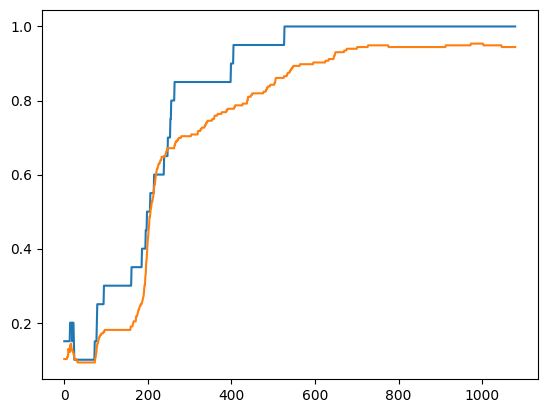

In [36]:
m.plot('accuracy')

In [35]:
model

Mehrkanoon(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=856, out_features=300, bias=True)
    (1): RandomFourierFeatureLayer()
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): RandomFourierFeatureLayer()
    (4): Linear(in_features=100, out_features=9, bias=True)
  )
)